<a href="https://colab.research.google.com/github/eip4-mars/EIP4P2/blob/master/Session8/Sess8_Drones_SRGAN_UF_4_176.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf eva4_lib
!git clone https://github.com/eip4-mars/eva4_lib.git

Cloning into 'eva4_lib'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 128 (delta 72), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (128/128), 38.96 KiB | 7.79 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [ ]:
  
import argparse
import os
from math import log10

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchsummary import summary


from eva4_lib.utils import pytorch_ssim
from eva4_lib.utils.srgan_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from eva4_lib.utils.srgan_loss import GeneratorLoss
from eva4_lib.models.srgan_model import Generator, Discriminator

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi

Sat Oct  3 06:23:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!unzip /content/gdrive/My\ Drive/EVA4P2/Sess2_Drones/Session_2_Dataset.zip
!mkdir data
!mkdir data/train
!mkdir data/val
!ls -Q Session\ 2\ Dataset/Large\ QuadCopters | head -4800 | xargs -i mv Session\ 2\ Dataset/Large\ QuadCopters/{} /content/data/train/
!mv Session\ 2\ Dataset/Large\ QuadCopters/* /content/data/val/
!rm -rf Session\ 2\ Dataset
!mkdir statistics
!mkdir chkpt
clear_output()
!ls /content/data/train|wc -l
!ls /content/data/val|wc -l

4811
10


In [ ]:
CROP_SIZE = 176  #training images crop size
UPSCALE_FACTOR = 4  #2/4/8
TRAIN_ROOT = '/content/data/train/'
VAL_ROOT = '/content/data/val/'


In [ ]:
train_set = TrainDatasetFromFolder(TRAIN_ROOT, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(VAL_ROOT, upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

# Decide which device we want to run on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


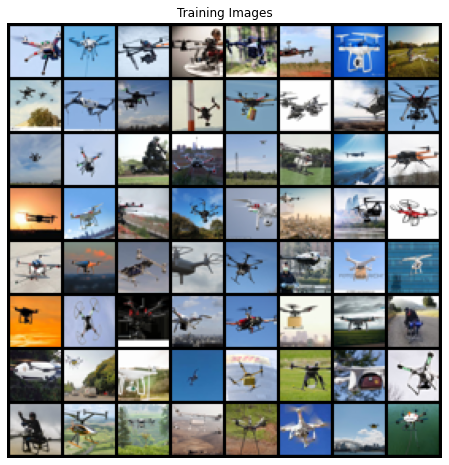

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
netG = Generator(UPSCALE_FACTOR).to(device)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator().to(device)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# generator parameters: 734211
# discriminator parameters: 5215425


In [ ]:
summary(netG, input_size=(3,44,44))
summary(netD, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 44, 44]          15,616
              ReLU-2           [-1, 64, 44, 44]               0
            Conv2d-3           [-1, 64, 44, 44]          36,928
       BatchNorm2d-4           [-1, 64, 44, 44]             128
              ReLU-5           [-1, 64, 44, 44]               0
            Conv2d-6           [-1, 64, 44, 44]          36,928
       BatchNorm2d-7           [-1, 64, 44, 44]             128
     ResidualBlock-8           [-1, 64, 44, 44]               0
            Conv2d-9           [-1, 64, 44, 44]          36,928
      BatchNorm2d-10           [-1, 64, 44, 44]             128
             ReLU-11           [-1, 64, 44, 44]               0
           Conv2d-12           [-1, 64, 44, 44]          36,928
      BatchNorm2d-13           [-1, 64, 44, 44]             128
    ResidualBlock-14           [-1, 64,

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Initialize BCELoss function
generator_criterion = GeneratorLoss().to(device)
netD.apply(weights_init)
netG.apply(weights_init)
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters()) # , lr=lr, betas=(beta1, 0.999)
optimizerG = optim.Adam(netG.parameters())

In [ ]:
# Training Loop
START_EPOCH = 1
NUM_EPOCHS  = 40
print("Starting Training Loop...")
# For each epoch
for epoch in range(START_EPOCH, NUM_EPOCHS+START_EPOCH+1):
    # For each batch in the dataloader    
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        ############################################################
        ## The two lines below are added to prevent runetime error! ##
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        ############################################################
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        # fake_img = netG(z)
        # fake_out = netD(fake_img).mean()
        
        
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
            epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
            running_results['g_loss'] / running_results['batch_sizes'],
            running_results['d_score'] / running_results['batch_sizes'],
            running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        val_images = []
        index = 0
        for val_lr, val_hr_restore, val_hr in val_bar:
            index += 1
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size
            lr = val_lr
            hr = val_hr
            if torch.cuda.is_available():
                lr = lr.cuda()
                hr = hr.cuda()
            sr = netG(lr)
    
            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size
            batch_ssim = pytorch_ssim.ssim(sr, hr).item()
            valing_results['ssims'] += batch_ssim * batch_size
            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
            val_bar.set_description(
                desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                    valing_results['psnr'], valing_results['ssim']))

            val_images.extend(
                [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                    display_transform()(sr.data.cpu().squeeze(0))])
        val_images = torch.stack(val_images)
        val_images = torch.chunk(val_images, val_images.size(0) // 15)
        val_save_bar = tqdm(val_images, desc='[saving training results]')
        index = 1
        for image in val_save_bar:
            image = utils.make_grid(image, nrow=3, padding=5)
            utils.save_image(image, out_path + 'UF4_epoch_%d_index_%d.png' % (epoch, index), padding=5)
            index += 1

    # save model parameters
    # save loss\scores\psnr\ssim
    results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
    results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
    results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
    results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])

    if epoch % 10 == 0 or epoch == 1 or epoch == NUM_EPOCHS:
        torch.save(netG.state_dict(), 'chkpt/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
        torch.save(netD.state_dict(), 'chkpt/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
        out_path = 'statistics/'
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                    'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

  0%|          | 0/301 [00:00<?, ?it/s]

Starting Training Loop...


[1/40] Loss_D: 0.9696 Loss_G: 0.0187 D(x): 0.6457 D(G(z)): 0.6112: 100%|██████████| 301/301 [05:27<00:00,  1.09s/it]
[converting LR images to SR images] PSNR: 20.9412 dB SSIM: 0.8182: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
[2/40] Loss_D: 1.0001 Loss_G: 0.0110 D(x): 0.0015 D(G(z)): 0.0010: 100%|██████████| 301/301 [05:25<00:00,  1.08s/it]
[converting LR images to SR images] PSNR: 24.2993 dB SSIM: 0.8474: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]
[3/40] Loss_D: 1.0000 Loss_G: 0.0094 D(x): 0.0000 D(G(z)): 0.0000: 100%|██████████| 301/301 [05:25<00:00,  1.08s/it]
[converting LR images to SR images] PSNR: 26.6706 dB SSIM: 0.8721: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]
[saving training results]: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]
[4/40] Loss_D: 1.0000 Loss_G: 0.0083 D(x): 0.0000 D(G(z)): 0.0000: 100%|██████████| 3

In [ ]:
# SV_LOC = 'DCGAN_cars.pt'
# save_jit(netG,SV_LOC)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

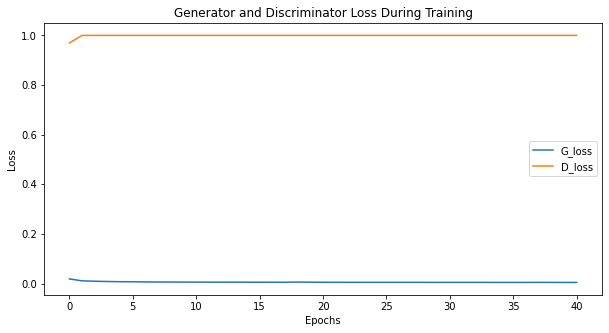

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(results['g_loss'],label="G_loss")
plt.plot(results['d_loss'],label="D_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

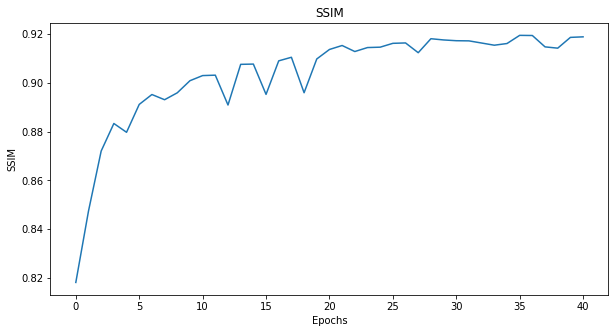

In [ ]:
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(results['ssim'],label="G_loss")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.show()

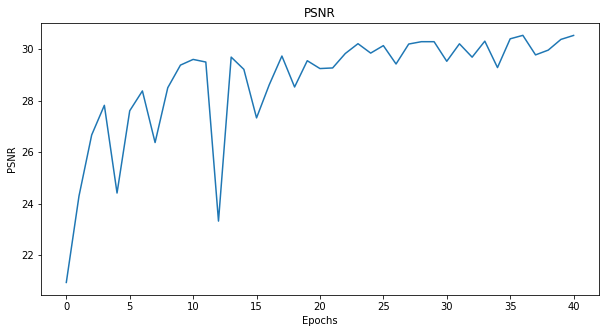

In [ ]:
plt.figure(figsize=(10,5))
plt.title("PSNR")
plt.plot(results['psnr'],label="G_loss")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
torch.save(netD, 'SRGAN_Drone_NetD.pth')
torch.save(netG, 'SRGAN_Drone_NetG.pth')

Mounted at /content/gdrive


In [ ]:
###  convert model to Onnx runtime

x = torch.randn(1, 3, 400, 400, requires_grad=True).to(device)
torch_out = netG(x)

batch_size = 1
torch.onnx.export(netG,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "SRGAN_Drone_NetG.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}},
                  example_outputs = torch.randn(1,3,256,256))


torch_out1 = netD(x)
torch.onnx.export(netD,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "SRGAN_Drone_NetD.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}},
                  example_outputs = torch.randn(1,1,1,1))

!cp SRGAN_Drone* /content/gdrive/My\ Drive/EVA4P2/Sess8/

In [ ]:
!zip Uf4_176.zip /content/training_results/SRF_4/*

In [ ]:
!pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 4.3MB/s 
     |████████████████████████████████| 3.8MB 42.7MB/s 


In [ ]:
import onnx

onnx_model = onnx.load("/content/SRGAN_Drone_NetG.onnx")
onnx.checker.check_model(onnx_model)



In [ ]:
def denorm_numpy(x):
    x_norm = (x - x.min()) / (x.max() - x.min())
    return x_norm

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

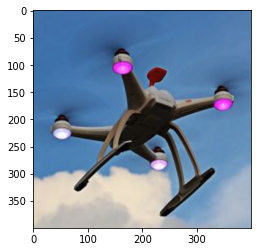

In [ ]:
from PIL import Image
im = Image.open("/content/drones-256x256.jpg").resize((400,400))
im

np_im_in = np.array(im).astype(np.float32)/255
plt.imshow(np_im_in)
np_im = np.moveaxis(np_im_in, 2 ,0)
np_im = np.expand_dims(np_im, 0)


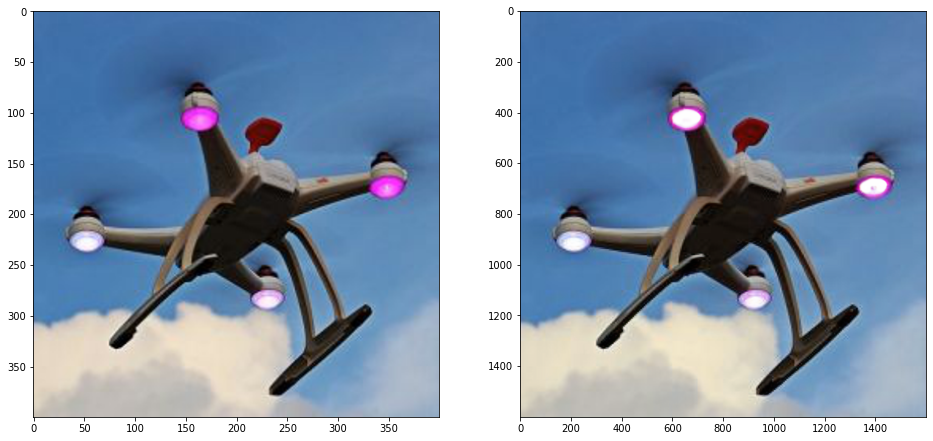

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("SRGAN_Drone_NetG.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: np_im}
ort_outs = ort_session.run(None, ort_inputs)[0]

#out = denorm_numpy(ort_outs[0])
out = np.moveaxis(ort_outs[0], 0, 2)
plt.figure(figsize=(16, 20))
plt.subplot(1, 2, 1)
plt.imshow(np_im_in)
plt.subplot(1, 2, 2)
plt.imshow(out)


In [ ]:
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from PIL import Image
im = Image.open("/content/drones-256x256.jpg").convert('RGB')

def display_transform():
    return Compose([
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

im_t = display_transform()(im).unsqueeze(0).to(device)
im_t.shape
out_t = netG(im_t)

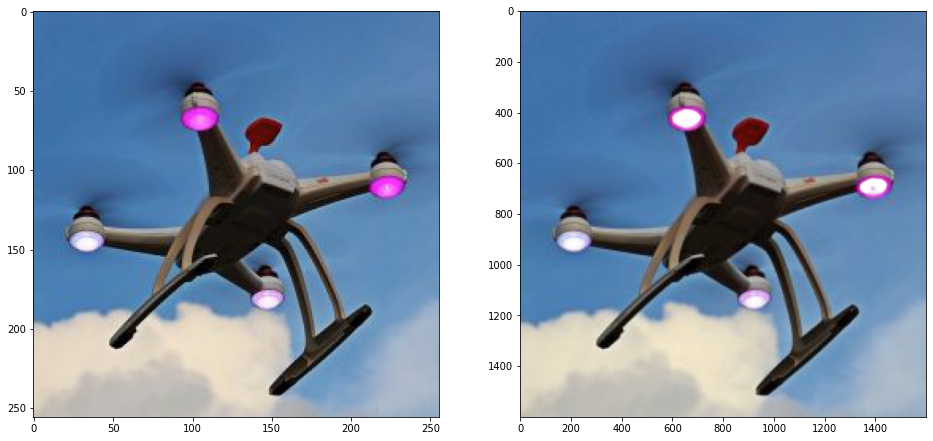

In [ ]:
out_np = out_t.squeeze().detach().cpu().numpy()
out = np.moveaxis(out_np, 0, 2)

plt.figure(figsize=(16, 20))
plt.subplot(1, 2, 1)
plt.imshow(np.array(im).astype(np.float32)/255)
plt.subplot(1, 2, 2)
plt.imshow(out)